## **_Stack Overflow Post's Analysis._**

_It is the largest, most trusted online community for developers to learn, share​ ​their programming ​knowledge, and build their careers.Stack Overflow is a question and answer site for professional and enthusiast programmers. It is a privately held website, the flagship site of the Stack Exchange Network, created in 2008 by Jeff Atwood and Joel Spolsky._ [More to Read](https://en.wikipedia.org/wiki/Stack_Overflow)

[StackOverflow Official Website](https://stackoverflow.com/)

**_Authenticating the google colab with Google SDK_**

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


**_Mouting Google Drive_**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

directory='/content/drive/My Drive/Comp8240'

!cd '/content/drive/My Drive/COMP8240'

**_reading project-id from the file_**

In [ ]:
with open('/content/drive/My Drive/COMP8240/google_cloud_project_id.txt','r') as f:
  project_id= f.read()

**_loading required libraries_**

In [ ]:
import os                                                                        #library to use operating system dependent functionality. (such as read, write files)
import re                                                                        #library to use regular expression matching operations.
import pandas as pd                                                              #library for high-level data manipulation
import numpy as np                                                               #library for working with arrrays.     
import matplotlib.pyplot as plt                                                  #library for plotting various plots.          
import seaborn as sns                                                            #library for seaborn plots
from   wordcloud import WordCloud, STOPWORDS                                     #library for word clouds, stopwords
import nltk                                                                      #NLTK library for text analysis.
import collections                                                               #library to store list, dict,set,tuple                  
from   collections import Counter                                                #library for importing counter, which is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.
import itertools                                                                 #This module implements a number of iterator building blocks inspired by constructs from APL, Haskell, and SM.
from   nltk.corpus import stopwords                                              #importing NLTK stopwords
from nltk.util import *                                                          #importing util package
from collections import defaultdict                                              #importing default dict package.

%matplotlib inline
#downloading stopwords and punkt packages.ite
nltk.download("stopwords")
nltk.download('punkt')
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**_Querying Big Query (Google Cloud Platform)_**

We have connected to Big Query ~Google cloud Platform using a project id (assigned to every user) and then ran a select query with limit to fetch only 500K records on **stackoverflow_posts** table from the **bigquery public data  stackoverflow database** and created a dataframe.

`BigQuery is a fully-managed, serverless data warehouse that enables scalable analysis over petabytes of data. It is a Platform as a Service that supports querying using ANSI SQL.`

In [ ]:
#Project Id for google cloud platform
project_id = project_id

#we ran a select query with like function to extract data which are having question marks in them.
stack_ovf_data = pd.io.gbq.read_gbq('''
  SELECT * FROM `bigquery-public-data.stackoverflow.stackoverflow_posts` where title LIKE '%?%' LIMIT 500000
''', project_id=project_id, dialect='standard')

print("Shape of the StackOverflow dataset:", stack_ovf_data.shape)
stack_ovf_data.head()

Shape of the StackOverflow dataset: (500000, 20)


,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,235982,How Code Color is Set in StackOverflow?,<p>The most favorite feature of StackOverflow ...,236062,3,0,NaT,2008-10-25 06:03:40.023000+00:00,10.0,2014-02-22 22:42:36.880000+00:00,2014-02-22 22:42:36.880000+00:00,None,2581872.0,Morgan Cheng,26349.0,None,1,12,javascript|syntax-highlighting,1284
1,687884,What is the correct way of using the Guid type...,<p>I have a .xsd file which I use to generate ...,723045,3,0,NaT,2009-03-26 23:02:47.157000+00:00,5.0,2014-03-17 16:40:07.183000+00:00,2009-03-27 17:32:30.967000+00:00,Kovey,46832.0,Kovey,46832.0,None,1,17,xsd|guid|xsd.exe,20808
2,373234,How can I grab my local changelist and send it...,<p>How can I grab my local changelist and send...,373434,3,1,NaT,2008-12-17 00:04:08.087000+00:00,4.0,2015-10-19 23:35:57.083000+00:00,2015-10-19 23:35:57.083000+00:00,None,46869.0,WJ B,46869.0,None,1,13,perforce,5995
3,520030,Why is there no Linq method to return distinct...,<p>I want to get the distinct values in a list...,520046,3,0,NaT,2009-02-06 11:51:53.150000+00:00,15.0,2010-10-08 18:29:26.863000+00:00,NaT,None,NaN,Keith,905.0,None,1,42,c#|linq|distinct,10620
4,395321,Is it Possible to Make a Generic Control in .N...,<p>I've got the following Generic usercontrol ...,395446,4,0,NaT,2008-12-27 19:32:45.660000+00:00,5.0,2010-11-29 12:57:56.623000+00:00,2010-11-29 12:57:56.623000+00:00,Roberto Bonini,16587.0,Roberto Bonini,5648.0,None,1,9,c#|.net|winforms|generics|user-controls,5716


## **_Exploratory Analysis_**

**_Keeping only important columns in the dataframe for further analysis_**

In [ ]:
stack_ovf_clean_data = stack_ovf_data[["tags","body","title","answer_count","creation_date","last_activity_date"]]

#Pre-processing answer_count column.
stack_ovf_clean_data["answer_count"]=stack_ovf_clean_data["answer_count"].fillna(0)
stack_ovf_clean_data["answer_count"]=stack_ovf_clean_data["answer_count"].astype(int)

**_Removing tags column with empy strings._**

_Plotting the graph for top 20 answer counts( answer counts ~ shows how many answers have been posted for every post)_

In [ ]:
posts_answer_counts = pd.DataFrame()
posts_answer_counts= stack_ovf_clean_data["answer_count"].value_counts(ascending=False)

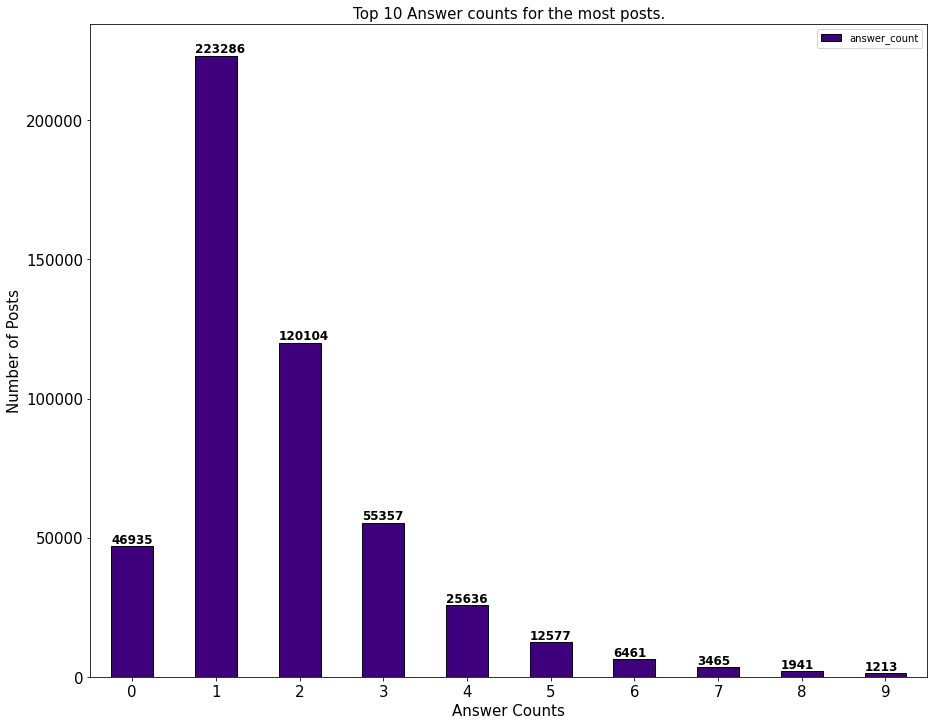

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=posts_answer_counts[:10].sort_index(ascending=True).plot.bar(x='answer_count',
                      ax=ax,fontsize=15,cmap="Purples_r" ,edgecolor="black")

ax.set_title("Top 10 Answer counts for the most posts.",size=15)
ax.legend().remove()
plt.xlabel("Answer Counts",size=15)
plt.ylabel("Number of Posts",size=15)

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360)
plt.show()

In [ ]:
posts_wo_answer=posts_answer_counts[0]

print("The",(posts_wo_answer/500000)*100,"% posts have no answers on the StackOverflow.")

The 9.386999999999999 % posts have no answers on the StackOverflow.


**_We observe that 9.386% posts on the StackOverflow are unanswered._**

----

**_Plotting how answer counts varies with time._**

In [ ]:
stack_ovf_clean_data['creation_date'] = pd.to_datetime(stack_ovf_clean_data['creation_date']) #converting created_at column to datetime

In [ ]:
#Craeting hour, date(full date), only date value, only month value, only year value columns for futhere analysis.
stack_ovf_clean_data['creation_hour'] = stack_ovf_clean_data['creation_date'].dt.hour #creating hour
stack_ovf_clean_data['create_date_sh'] = stack_ovf_clean_data['creation_date'].dt.date
stack_ovf_clean_data['only_date'] = stack_ovf_clean_data['creation_date'].apply(lambda x : str(x)[8:10])
stack_ovf_clean_data['only_month'] = stack_ovf_clean_data['creation_date'].apply(lambda x : str(x)[5:7])
stack_ovf_clean_data["only_year"] = stack_ovf_clean_data["creation_date"].apply(lambda x: str(x)[0:4])

<Figure size 7200x6480 with 0 Axes>

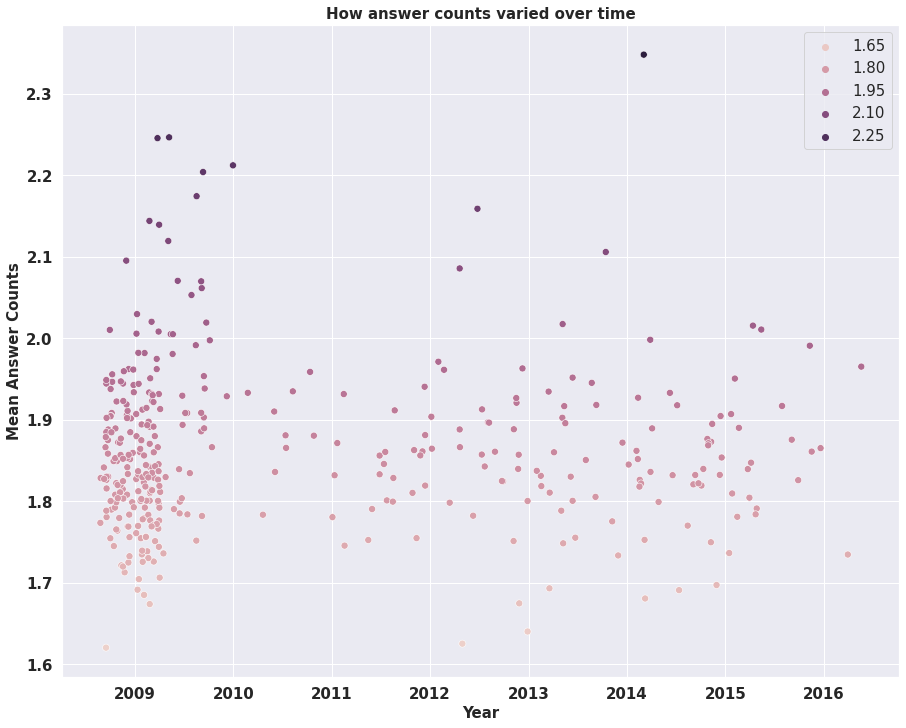

<Figure size 7200x6480 with 0 Axes>

In [ ]:
aggdf = stack_ovf_clean_data.reset_index().groupby(by=['only_month', 'only_date']).agg({'answer_count':'mean'}).reset_index().rename(columns={'answer_count':'mean_answer_count'})
aggdf['month_date'] = stack_ovf_clean_data["create_date_sh"]

sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(15, 12))
sns.scatterplot(x='month_date',y='mean_answer_count', data=aggdf,s=50,hue="mean_answer_count",color="yellow") 
plt.xlabel("Year",size=15,weight='bold')

plt.ylabel("Mean Answer Counts",size=15,weight='bold')
plt.xticks(size=15,weight='bold')
plt.yticks(size=15,weight='bold')
plt.legend(fontsize=15)
plt.title("How answer counts varied over time",size=15,weight='bold')
plt.figure(figsize=(100,90))

**_We observe that the 2009 has most question answered with a cluster of mean values for answer count on daily basis. From 2010 till 2016, we witness the answers were not posted on daily basis and have a scatter plot of answering counts with a wide spread._**

-----

**_Plotting which hour of the day has most posts_**

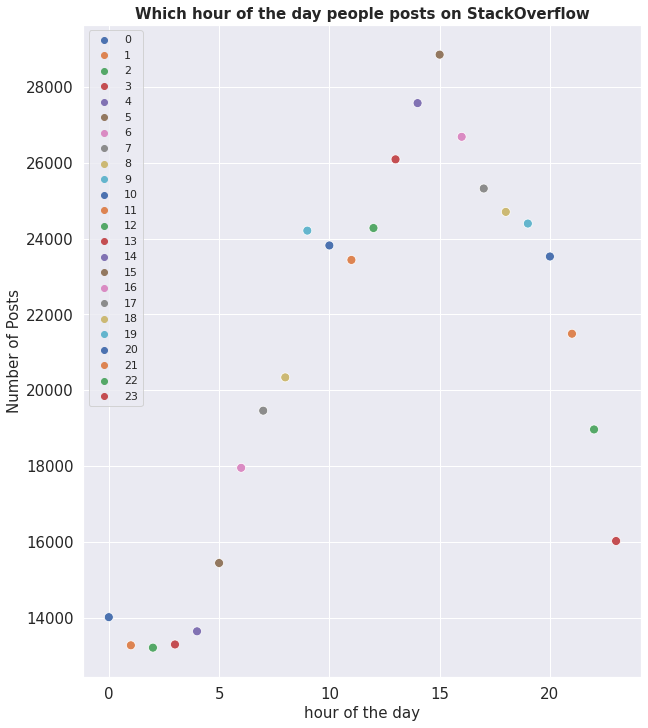

In [ ]:
aggdf_1 =pd.DataFrame()
aggdf_1=(stack_ovf_clean_data['creation_hour'].value_counts().sort_index(ascending=True)).astype(int)
aggdf_1=aggdf_1.reset_index().rename(columns={"index":"hour","creation_hour":"Counts"})
fig, ax = plt.subplots(figsize=(10, 12))
sns.set(color_codes=True)
sns.scatterplot(x='hour',y='Counts', data=aggdf_1,s=80,color="red",hue="hour",palette="deep") 

plt.xlabel("hour of the day",size=15)

plt.ylabel("Number of Posts",size=15)
plt.title("Which hour of the day people posts on StackOverflow",size=15,weight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(loc="upper left")

**_we observe that people ask questions on StackOverlow throughout the day, around 1400 we have most questions posted and then at 1500 hours we have nearly 30K posts._**

------------

**_Removing rows in tags column with empy string , this means they dont have any tags._**

In [ ]:
post_wo_tags =len(stack_ovf_clean_data[stack_ovf_clean_data["tags"]==''])

print("The ",(post_wo_tags/100000)*100,"% posts have no tags (So we are removing them).")

The  0.0 % posts have no tags (So we are removing them).


In [ ]:
stack_ovf_clean_data=stack_ovf_clean_data[stack_ovf_clean_data["tags"]!='']

In [ ]:
labels_list = [tags for tags in stack_ovf_clean_data["tags"]]

In [ ]:
labels_list_length = [len(tags1.split("|")) for tags1 in labels_list] 

stack_ovf_clean_data["labels_list_length"] = labels_list_length

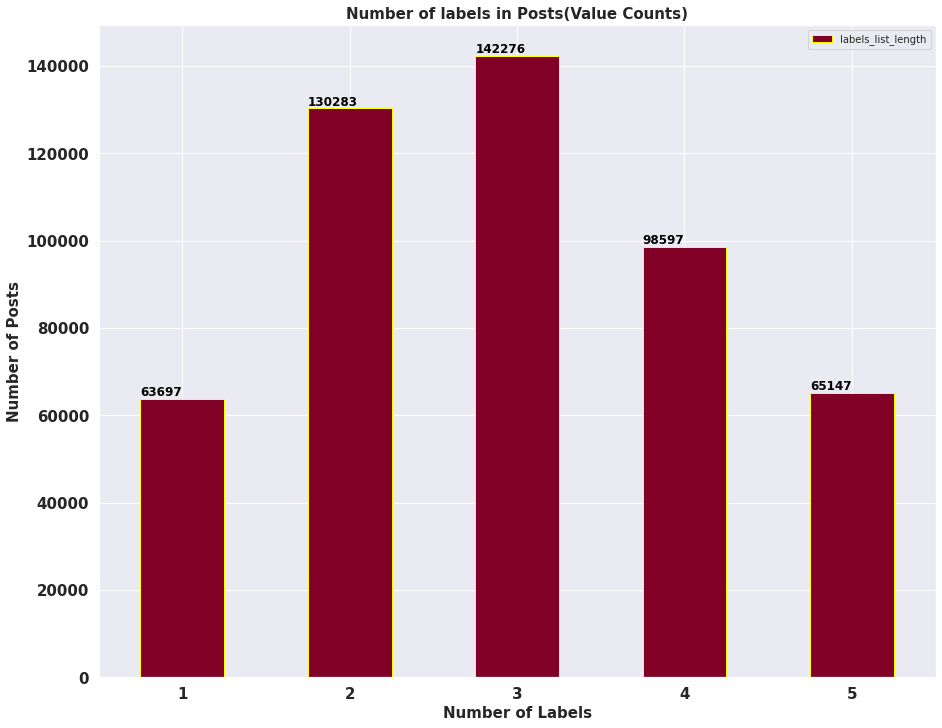

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=stack_ovf_clean_data["labels_list_length"].value_counts().sort_index(ascending=True).plot.bar(x='labels_list_length',
                      ax=ax,fontsize=15,cmap="YlOrRd_r" ,edgecolor="Yellow")

ans_plot.set_title("Number of labels in Posts(Value Counts)",size=15,weight='bold')
ans_plot.legend().remove()
plt.xlabel("Number of Labels",size=15,weight='bold')
plt.ylabel("Number of Posts",size=15,weight='bold')

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360,weight='bold')
plt.yticks(weight='bold')
plt.show()

**_We observe that 142K posts have highest number of 3 lables, where 65K posts have 5 labels(most label count)._**

In [ ]:
labels_list = [tags for tags in stack_ovf_clean_data["tags"]] 
labels_list = [tags.lower().split("|") for tags in labels_list] 

In [ ]:
#chain function which takes a series of iterables and returns one iterable. 
labels_list = list(itertools.chain(*labels_list)) 

#counter function ~ creating a container that stores elements as dictionary keys (words), and their counts(word frequency) are stored as dictionary values
counts_labels = collections.Counter(labels_list)


In [ ]:
label_counts_df = pd.DataFrame(counts_labels.most_common(),columns=["labels","counts"])

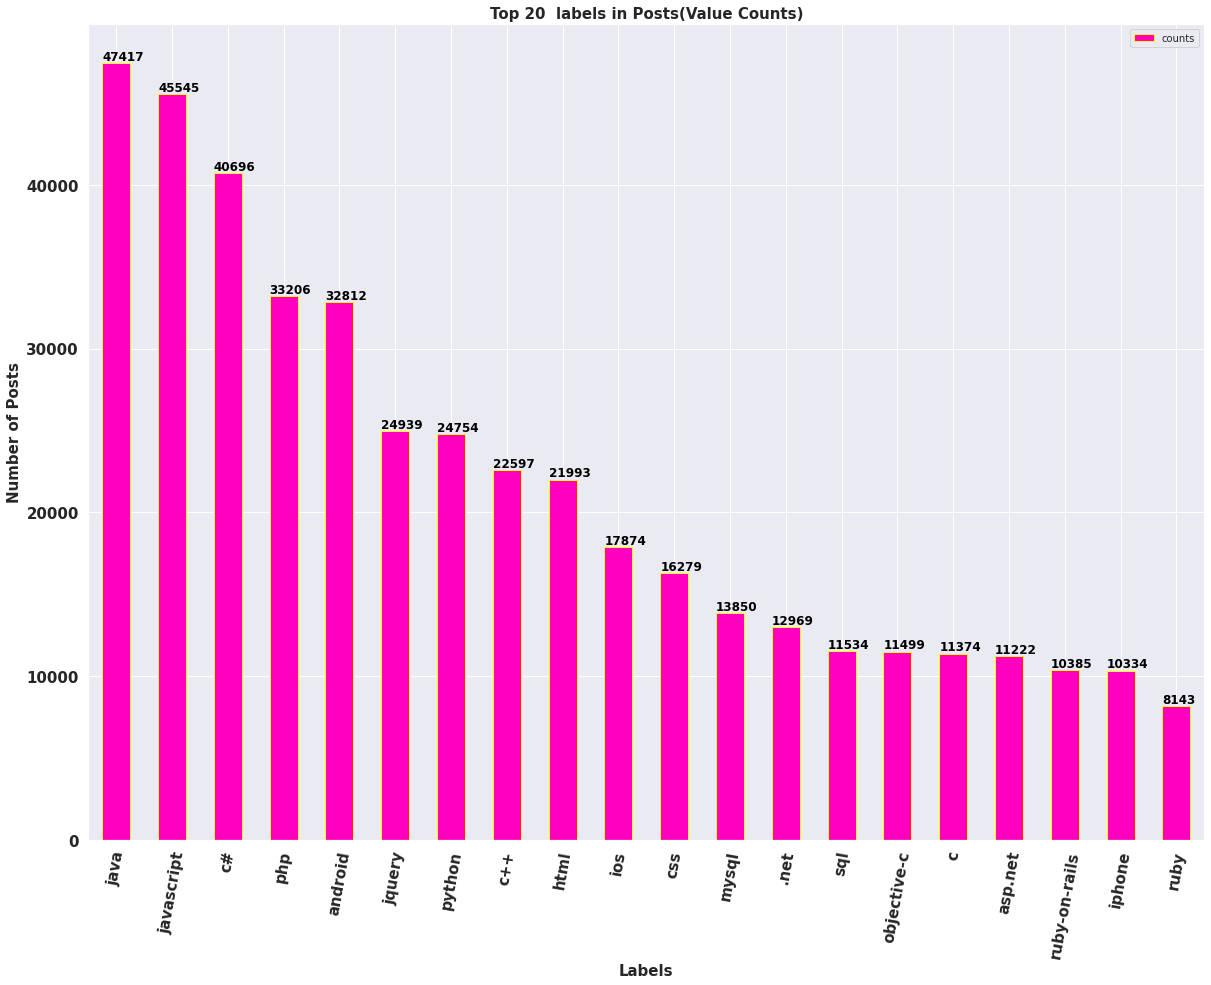

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
ans_plot=label_counts_df[:20].plot.bar(x='labels',
                      ax=ax,fontsize=15,cmap="gist_rainbow_r" ,edgecolor="Yellow")

ans_plot.set_title("Top 20  labels in Posts(Value Counts)",size=15,weight='bold')
ans_plot.legend().remove()
plt.xlabel("Labels",size=15,weight='bold')
plt.ylabel("Number of Posts",size=15,weight='bold')


for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=80,weight='bold')
plt.yticks(weight='bold')
plt.show()

**_We observe that the java is most used label with a frequency of 47K, javascript is next in terms of frequency in posts. The plot shows top 20 labels in the posts._**

-----------------------

**_Removing the hyperlinks and url tags as well_**

In [ ]:
stack_ovf_clean_data["title"] = stack_ovf_clean_data["title"].str.replace("<.*?>", " ")
stack_ovf_clean_data["title"] = stack_ovf_clean_data["title"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

stack_ovf_clean_data["body"] = stack_ovf_clean_data["body"].str.replace("<.*?>", " ")
stack_ovf_clean_data["body"] = stack_ovf_clean_data["body"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

--------

**_Question lengths for top programming languages_**

In [ ]:
#Calculating lenght of questions(body column) and store it in separate column.
stack_ovf_clean_data.loc[:,'length_of_question'] = stack_ovf_clean_data.loc[:,'body'].apply(len)

In [ ]:
#Creating a new df and store tags splitted on | (pipe).
prog_df=pd.DataFrame()
prog_df['labels'] = stack_ovf_clean_data['tags'].str.split('|')

In [ ]:
#function to filter top programming languages from the list.
def prog_lang(labels):
    lang_list = [lang for lang in labels if lang in ['python','java','sql','r','javascript',"c","c#"]] 
    return lang_list

In [ ]:
prog_df['labels'] = prog_df['labels'].apply(prog_lang)

#getting list of labels with only one value.
prog_df= prog_df[(prog_df['labels'].apply(len) > 0) & (prog_df['labels'].apply(len) < 2)]

In [ ]:
#converting list of prog languages to string.
prog_df['labels'] = prog_df['labels'].apply(''.join)

In [ ]:
prog_df['length_of_question'] = stack_ovf_clean_data['length_of_question']

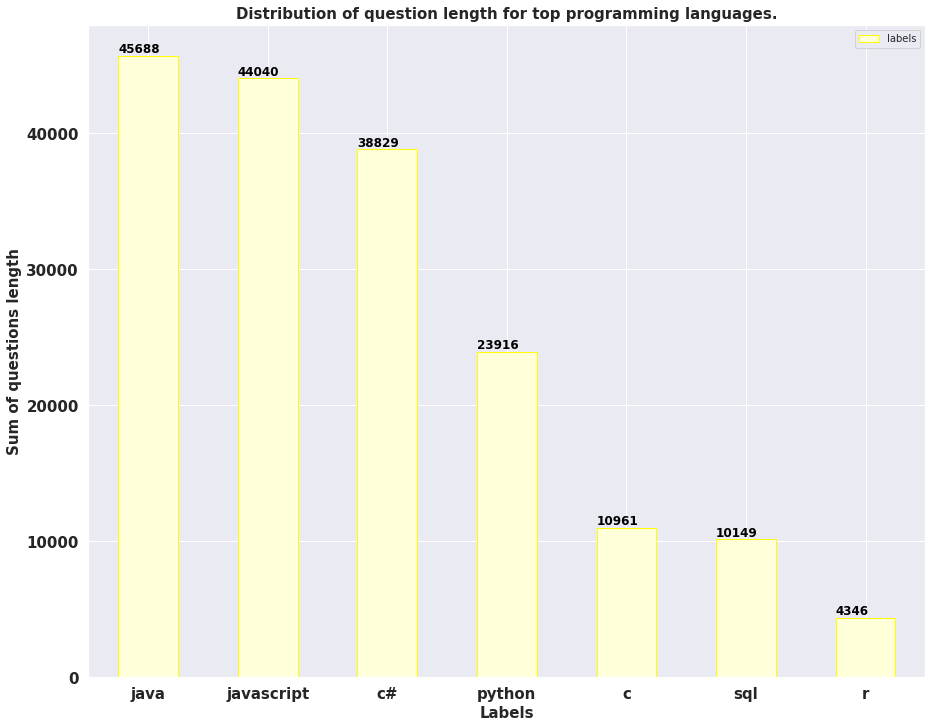

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=prog_df["labels"].value_counts().plot.bar(x='labels',
                      ax=ax,fontsize=15,cmap="YlGnBu" ,edgecolor="Yellow")

ans_plot.set_title("Distribution of question length for top programming languages.",size=15,weight='bold')
ans_plot.legend().remove()
plt.xlabel("Labels",size=15,weight='bold')
plt.ylabel("Sum of questions length",size=15,weight='bold')

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360,weight='bold')
plt.yticks(weight='bold')
plt.show()

**_We obseverve that the java tag(label) has most questions with most length (which is obvious as java is the most used label by people on the StackOverflow._**

-------

**_changing the case of the words in the tags column_**

In [ ]:
# stop_words = set(stopwords.words("english"))
stack_ovf_clean_tags = ' '.join(stack_ovf_clean_data['tags'].str.lower())

**_Printing Word cloud of the tags_**

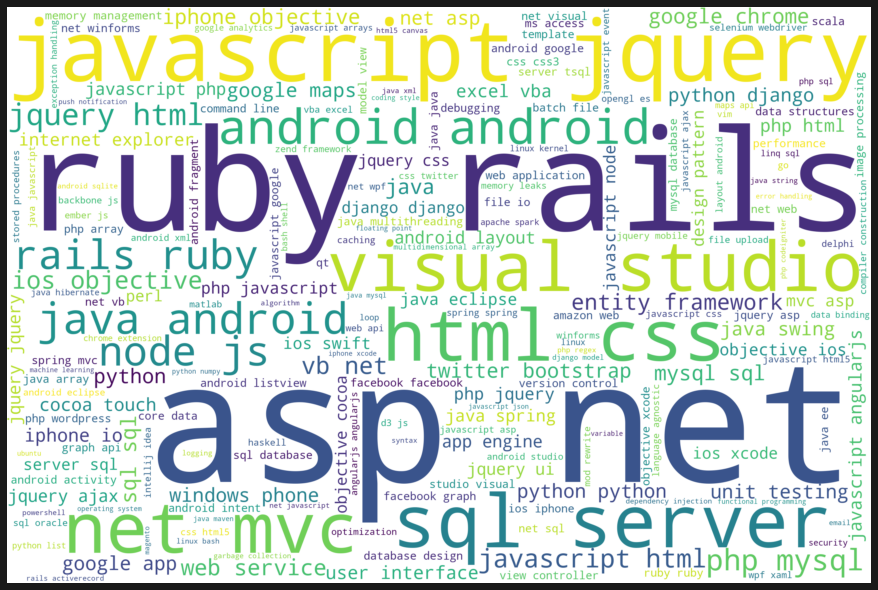

In [ ]:
wordcloud = WordCloud(width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(stack_ovf_clean_tags)
fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**_WordCloud illustrated the output of the word frequency of the labels, ruby rails, asp net, javascript are the highest used label._**

## **_Data Preparation_**

**_Making label column as per requirement for input to the fasttext module._**

In [ ]:
stack_ovf_clean_data["tags"] = [item.replace("|", " __label__") for item in stack_ovf_clean_data["tags"]]
stack_ovf_clean_data['tags'] ='__label__' + stack_ovf_clean_data['tags'].astype(str)

In [ ]:
 stack_ovf_dataset =stack_ovf_clean_data[["tags","title"]]

**_Keeping 100K rows for the fasttext data preparation._**

In [ ]:
# #Creating dataset with 100K records.
stack_ovf_dataset=stack_ovf_dataset[:100000]

In [ ]:
stack_ovf_dataset

,tags,title
0,__label__javascript __label__syntax-highlighting,How Code Color is Set in StackOverflow?
1,__label__xsd __label__guid __label__xsd.exe,What is the correct way of using the Guid type...
2,__label__perforce,How can I grab my local changelist and send it...
3,__label__c# __label__linq __label__distinct,Why is there no Linq method to return distinct...
4,__label__c# __label__.net __label__winforms __...,Is it Possible to Make a Generic Control in .N...
...,...,...
99995,__label__events __label__click __label__onclic...,WAZE for web is not responding to register why?
99996,__label__mysql __label__sql __label__ms-access...,How do I create and display an Access 2010 dat...
99997,__label__c __label__autocomplete __label__komo...,How can I get Komodo Edit 7 to autocomplete C?
99998,__label__jenkins __label__continuous-deployment,From where I can download Jenkins build-pipeli...


**_Saving dataset as text file._**

In [ ]:
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.txt', stack_ovf_dataset.values, fmt='%s', delimiter='\t')

In [ ]:
!head "/content/drive/My Drive/COMP8240/stack_ovf.txt"

__label__javascript __label__syntax-highlighting	How Code Color is Set in StackOverflow?
__label__xsd __label__guid __label__xsd.exe	What is the correct way of using the Guid type in a XSD file?
__label__perforce	How can I grab my local changelist and send it to someone else in Perforce?
__label__c# __label__linq __label__distinct	Why is there no Linq method to return distinct values by a predicate?
__label__c# __label__.net __label__winforms __label__generics __label__user-controls	Is it Possible to Make a Generic Control in .Net 3.5?
__label__url __label__pdf __label__hyperlink __label__bookmarks	Is it possible to link to a bookmark within a PDF using URL parameters?
__label__.net __label__windows __label__serial-port __label__lockup	Windows/.NET way to monitor/debug the serial port?
__label__ruby-on-rails __label__ruby __label__security __label__anonymous-users	Anonymous users in Rails -- security considerations?
__label__php __label__regex __label__preg-match	How do I get the Video

**_printing word count for the dataset file._**

In [ ]:
!wc "/content/drive/My Drive/COMP8240/stack_ovf.txt"

  100000  1333633 11256290 /content/drive/My Drive/COMP8240/stack_ovf.txt


**_Splitting data into training, validation & testing._**

In [ ]:
train_proportion= round(len(stack_ovf_dataset)*0.70)
valid_proportion = round(len(stack_ovf_dataset)*0.15)
test_proportion = round(len(stack_ovf_dataset)*0.15)

In [ ]:
print("The training dataset proportion would have",train_proportion, "records.")
print("The validation dataset proportion would have",valid_proportion, "records.")
print("The testing dataset proportion would have",test_proportion , "records.")

The training dataset proportion would have 70000 records.
The validation dataset proportion would have 15000 records.
The testing dataset proportion would have 15000 records.


In [ ]:
train_dataset =pd.read_csv("/content/drive/My Drive/COMP8240/stack_ovf.txt", nrows=train_proportion,header=None)
valid_dataset =pd.read_csv("/content/drive/My Drive/COMP8240/stack_ovf.txt",skiprows=train_proportion,nrows=valid_proportion,header=None)
test_dataset =pd.read_csv("/content/drive/My Drive/COMP8240/stack_ovf.txt",skiprows=(train_proportion+valid_proportion),nrows=test_proportion,header=None)

**_Creating train valid & test files for the fasttext._**

In [ ]:
#Saving files for the training , validation & testing.
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.train', train_dataset.values, fmt='%s', delimiter='\t')
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.valid', valid_dataset.values, fmt='%s', delimiter='\t')
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.test', test_dataset.values, fmt='%s', delimiter='\t')

_The data extraction, EDA and data preparation has been completed. We will proceed to implement fasttext on the StackOverflow posts. We have kept 100K rows out of 500K records (after keeping questions with "?" sign explicitly). The distribution of these 100K rows is as 70% goes for the fastText model training, 15% for the validation of the model and rest 15% for the testing of model on unseen part of the whole dataset._

-----------

##**_Running fastText on StackOverflow Post's_**

In [ ]:
#Installing fastText
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

**_training fastText model_**

In [ ]:
!./fasttext  supervised -input "/content/drive/My Drive/COMP8240/stack_ovf.train" -output ./model_stack_ovf

Read 1M words
Number of words:  62005
Number of labels: 15470
Progress: 100.0% words/sec/thread:     576 lr:  0.000000 avg.loss: 12.154972 ETA:   0h 0m 0s


**_Checking score of the model on Validation dataset_**

In [ ]:
initial_score=!./fasttext test ./model_stack_ovf.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid"
initial_score

['N\t14947', 'P@1\t0.289', 'R@1\t0.101']

We observe that the initial modelling gives a Precision of 0.289 (~29%) with recall of 0.10 (10%). We can still make a better model with normalization and  other hyper-parameter tweaking. 

_(precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.)_

--------------------

## **_Making Model better_**

here, we are changing the case of words and removing some special characters as well using the sed Unix command.

In [ ]:
cat "/content/drive/My Drive/COMP8240/stack_ovf.txt" | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/content/drive/My Drive/COMP8240/stack_ovf.preprocessed.txt"

In [ ]:
train_dataset =pd.read_csv("/content/drive/My Drive/COMP8240/stack_ovf.preprocessed.txt", nrows=train_proportion,header=None)
valid_dataset =pd.read_csv("/content/drive/My Drive/COMP8240/stack_ovf.preprocessed.txt",skiprows=train_proportion,nrows=valid_proportion,header=None)
test_dataset =pd.read_csv("/content/drive/My Drive/COMP8240/stack_ovf.preprocessed.txt",skiprows=(train_proportion+valid_proportion),nrows=test_proportion,header=None)

In [ ]:
#Saving files for the training , validation & testing.
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.train', train_dataset.values, fmt='%s', delimiter='\t')
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.valid', valid_dataset.values, fmt='%s', delimiter='\t')
np.savetxt(r'/content/drive/My Drive/COMP8240/stack_ovf.test', test_dataset.values, fmt='%s', delimiter='\t')

**_modelling on pre-processed files_**

In [ ]:
!./fasttext  supervised -input "/content/drive/My Drive/COMP8240/stack_ovf.train" -output ./model_stack_ovf

Read 1M words
Number of words:  34266
Number of labels: 15131
Progress: 100.0% words/sec/thread:     671 lr:  0.000000 avg.loss: 11.593882 ETA:   0h 0m 0s


In [ ]:
upd_model_score= !./fasttext test ./model_stack_ovf.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid"
upd_model_score

['N\t14949', 'P@1\t0.401', 'R@1\t0.14']

_As we can see after applying `crude normalization` (same case of words throughout the document) and we observe that the measure of result relevancy increases from 0.29 to 0.401 ( increase of 0.11 units) with measure of truly relevant results increase from 0.10 to 0.14 (increase of 0.4)._

## **_Hyper-parameter tweaking_**

_Hyper-parameters are the parameters whose value used to control the learning process.  The first thing is to add increase the epochs for the modelling and test.I had implemented few other hyper-parameters as well such as learning rate, wordNgrams, loss function (hierarchical softmax)._

**_Increasing epochs_**

In [ ]:
!./fasttext  supervised -input "/content/drive/My Drive/COMP8240/stack_ovf.train" -output ./model_stack_ovf_ep15 -epoch 15

Read 1M words
Number of words:  34266
Number of labels: 15131
Progress: 100.0% words/sec/thread:     670 lr:  0.000000 avg.loss: 10.130357 ETA:   0h 0m 0s


In [ ]:
epoch15_score = !./fasttext test ./model_stack_ovf_ep15.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid"
epoch15_score

['N\t14949', 'P@1\t0.511', 'R@1\t0.179']

In [ ]:
!./fasttext  supervised -input "/content/drive/My Drive/COMP8240/stack_ovf.train" -output ./model_stack_ovf_ep25 -epoch 25

Read 1M words
Number of words:  34266
Number of labels: 15131
Progress: 100.0% words/sec/thread:     668 lr:  0.000000 avg.loss:  9.208025 ETA:   0h 0m 0s


In [ ]:
epoch25_score = !./fasttext test ./model_stack_ovf_ep25.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid"
epoch25_score

['N\t14949', 'P@1\t0.548', 'R@1\t0.192']

_Increasing the epochs to 25 has shown a jump of Precision from 0.40 to 0.548 (~55%) and recall also from 0.14 to 0.19._

**_WordN- grams and learning rate_**

*Plotting Unigram & Bigrams*

In [ ]:
# Creating a func() called build_ngrams to analyse data in the form of unigrams, bigrams, ngrams etc.
def build_ngrams(stack_ovf_text, ngram):
    stack_ovf_text = stack_ovf_text.lower()
    stack_ovf_text = remove_space.sub(' ', stack_ovf_text)
    stack_ovf_text = bad_symbols.sub(' ', stack_ovf_text)
    stack_ovf_text = ' '.join(word for word in stack_ovf_text.split() if word not in STOPWORDS) 
    tokenize = nltk.word_tokenize(stack_ovf_text)
    return list(ngrams(tokenize, ngram))

In [ ]:
# Handling spaces in text and bad symbols and eliminating those using regex.
remove_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
# Looping over questions list and building unigrams from the list.
onegram_tags_freq = defaultdict(int)
for sentence in stack_ovf_dataset['title']:
    for word in build_ngrams(sentence, 1):
        onegram_tags_freq[word] = onegram_tags_freq[word] + 1

In [ ]:
def plot_horizontal_bar(data, title):
    plt.figure(figsize=(20, 15))
    freq = pd.DataFrame(sorted(data.items(), key=lambda x: x[1]), columns=['Words','Count'])
    sns.barplot(x='Count', y='Words', data=freq.sort_values(by="Count", ascending=True).tail(30))
    plt.title(title)
    plt.tight_layout()
    plt.show()

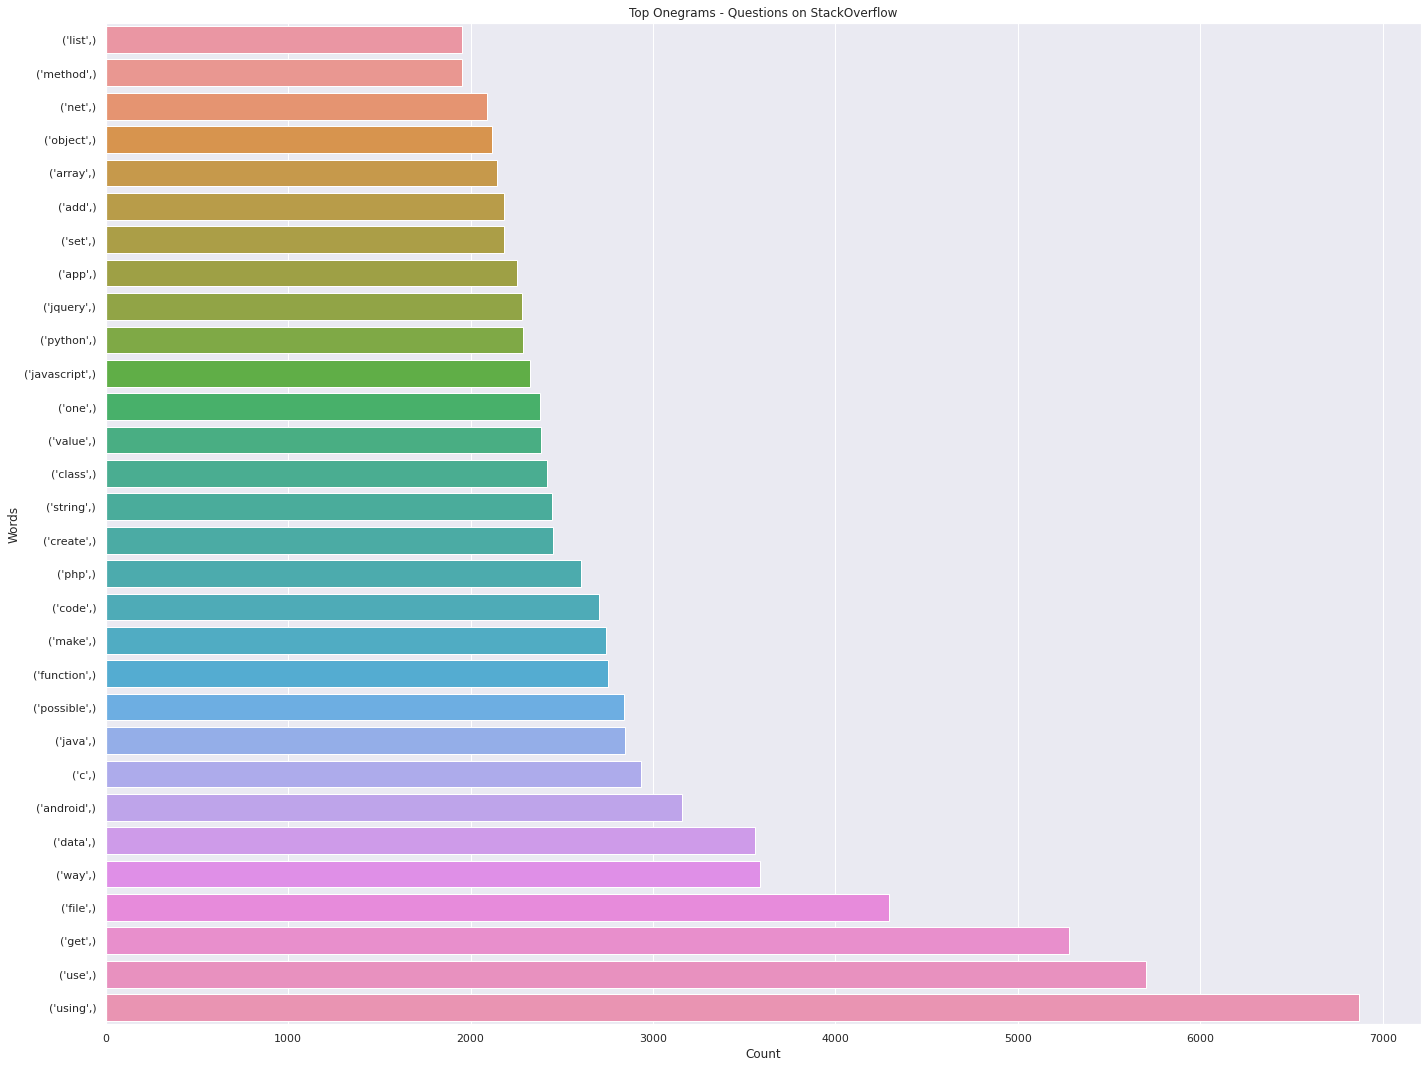

In [ ]:
plot_horizontal_bar(onegram_tags_freq, 'Top Onegrams - Questions on StackOverflow')

In [ ]:
bigrams_tags_freq = defaultdict(int)
for sentence in stack_ovf_dataset['title']:
    for word in build_ngrams(sentence, 2):
        bigrams_tags_freq[word] = bigrams_tags_freq[word] + 1

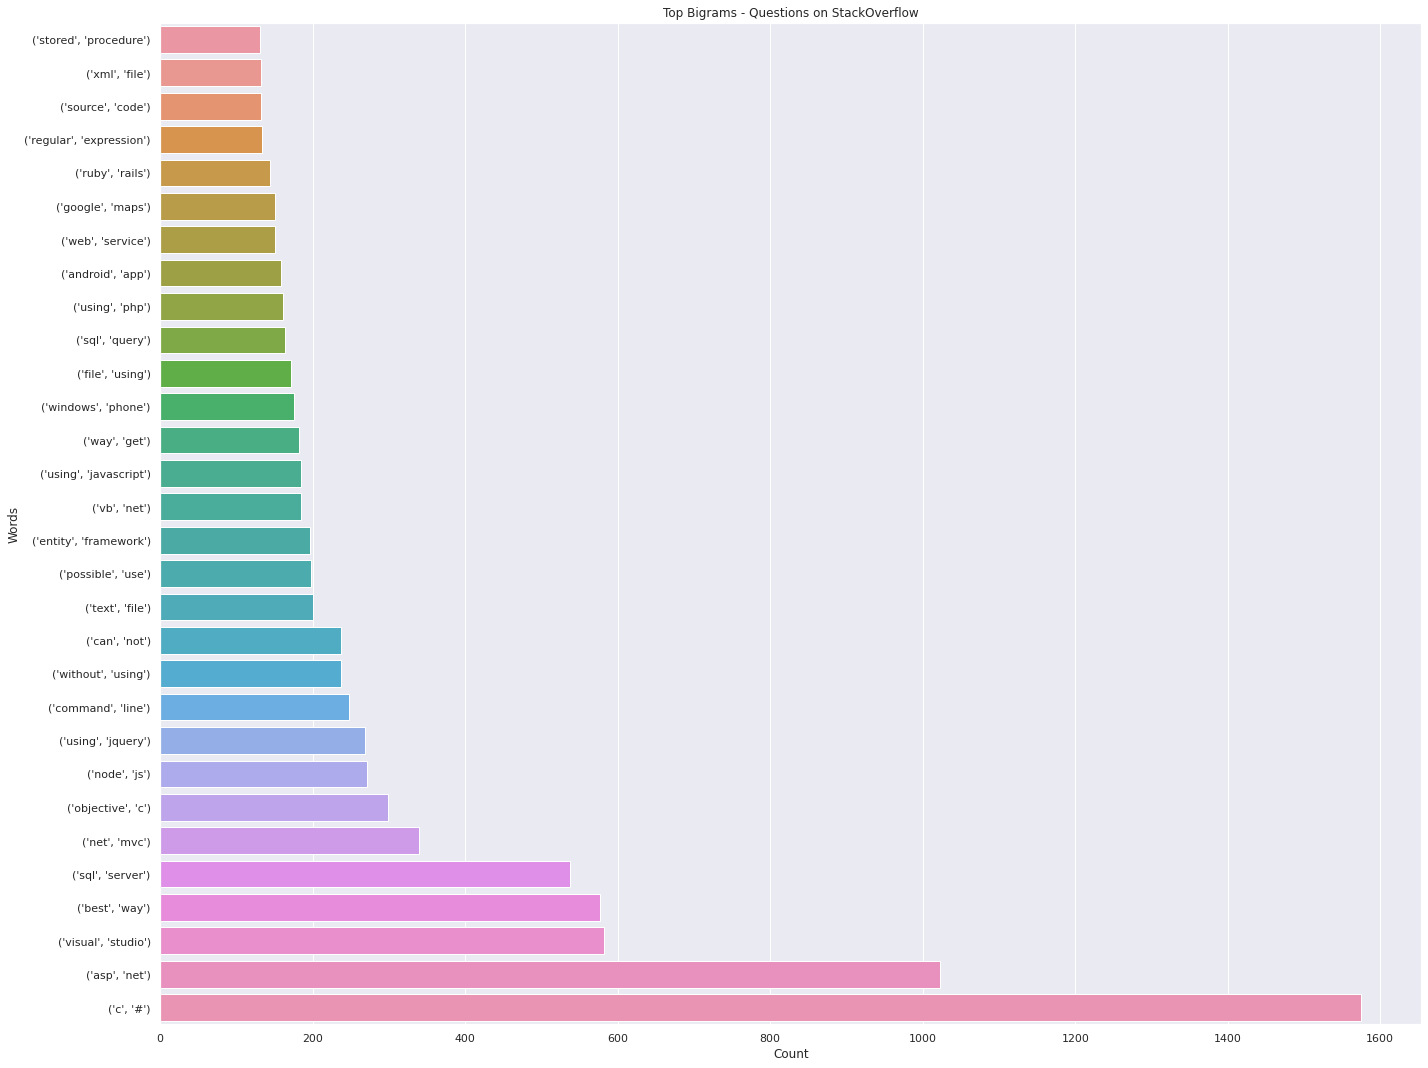

In [ ]:
plot_horizontal_bar(bigrams_tags_freq, 'Top Bigrams - Questions on StackOverflow')

In [ ]:
!./fasttext  supervised -input "/content/drive/My Drive/COMP8240/stack_ovf.train" -output ./model_stack_ovf_wg -lr 1.0 -epoch 25 -wordNgrams 2

Read 1M words
Number of words:  34266
Number of labels: 15131
Progress: 100.0% words/sec/thread:     662 lr:  0.000000 avg.loss:  5.059479 ETA:   0h 0m 0s


In [ ]:
wg_score = !./fasttext test ./model_stack_ovf_wg.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid"
wg_score

['N\t14949', 'P@1\t0.569', 'R@1\t0.199']

**_The wordNgram ==2 has increased the precision from 54 to 56.9 and recall from 0.189 to 0.199_**

**_Scaling Up_**

_Since we are training our model on a thousands of questions (34,266 words) with 15K+ labels and model training is slow. A potential solution to make the training faster is to use the hierarchical softmax, instead of the regular softmax. This can be done with the option -loss hs._

In [ ]:
!./fasttext  supervised -input "/content/drive/My Drive/COMP8240/stack_ovf.train" -output ./model_stack_ovf_sc -lr 1.0 -epoch 15 -wordNgrams 1 -bucket 2000000 -dim 70 -loss hs

Read 1M words
Number of words:  34266
Number of labels: 15131
Progress: 100.0% words/sec/thread:  302826 lr:  0.000000 avg.loss:  8.854852 ETA:   0h 0m 0s


In [ ]:
scaled_up_score = !./fasttext test ./model_stack_ovf_sc.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid"
scaled_up_score

['N\t14949', 'P@1\t0.613', 'R@1\t0.215']

*We have reached a precision score of **`0.61 from 0.29`** in below steps:*

* Pre-process training dataset (`changing words case`).

* tried different epochs (`15 & 25 epochs`).

* changing the learning rate (-lr option , `standard range [0.1 - 1.0]`).

* Using wordNgrams(-wordNgrams option, `standard range [1 - 5]`)

* scaled up training model with **`hierarchical softmax`** instead of regular softmax.

**_Score Comparison of Various Models on Validation Dataset_**

In [ ]:
data = {"Model" : ['Initial Model','Model with Normalization','Model (15 epochs)','Model (25 epochs)','Model (25 epochs,WordNGram,lr)','Model (15 epochs, lr, wordNgram,hs)'],
        "Precision": [initial_score[1],upd_model_score[1], epoch15_score[1],epoch25_score[1],wg_score[1],scaled_up_score[1]],
        "Recall":[initial_score[2], upd_model_score[2],epoch15_score[2],epoch25_score[2],wg_score[2],scaled_up_score[2]]}

score_df = pd.DataFrame(data)

score_df["Precision"] = score_df["Precision"].str.replace("P@1", "").str.replace("\t","")
score_df["Recall"] = score_df["Recall"].str.replace("R@1", "").str.replace("\t","")

#converting string column to numeric for plots.
score_df["Precision"] = pd.to_numeric(score_df["Precision"])
score_df["Recall"] = pd.to_numeric(score_df["Recall"])

score_df

,Model,Precision,Recall
0,Initial Model,0.289,0.101
1,Model with Normalization,0.401,0.140
2,Model (15 epochs),0.511,0.179
3,Model (25 epochs),0.548,0.192
4,"Model (25 epochs,WordNGram,lr)",0.569,0.199
5,"Model (15 epochs, lr, wordNgram,hs)",0.613,0.215


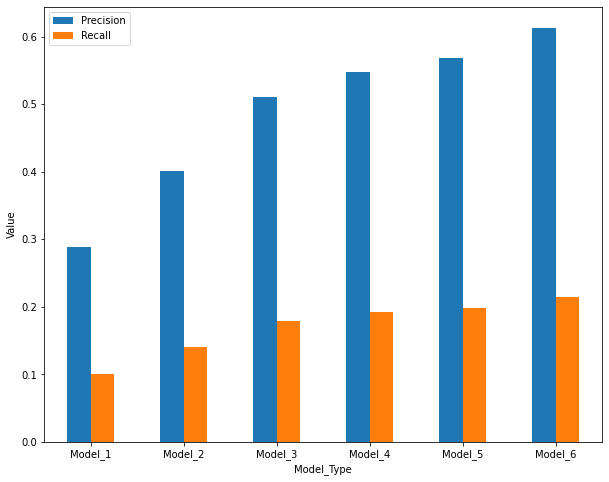

In [ ]:
score_df.plot(kind ='bar', x="Model",figsize = (10, 8))
plt.xticks(rotation=360)
plt.xlabel("Model_Type")
plt.xticks([0, 1, 2,3,4,5], ['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6'])
plt.ylabel("Value")
plt.show()

_We have seen our model precision has increased from 0.29 to 0.61 (32% increase) and recall has increase from 0.10 to 0.20 (10% increase). The final model with the scaling has shown high precision and recall._

* Model_1 : It is the initial model.

* Model_2: It is the classifier after applying crude normalization to the dataset.

* Model_3: This model has 15 epochs.

* Model_4: This model has 25 epochs.

* Model_5: This model has 25 epochs & lr & wordNgrams applied.

* Model_6: Scaled up model.


###**_`The final model has run with 15 epochs , learning rate 1.0 , words grams 1, bucket 2000000 and hierarchical softmax loss function (hs).`_**


## **_Score on test data._**

In [ ]:
!./fasttext test ./model_stack_ovf_sc.bin "/content/drive/My Drive/COMP8240/stack_ovf.test"

N	14957
P@1	0.618
R@1	0.217


**_Final model has given a precision of 0.618 and recall of 0.217 on the unseen dataset (test data)._**

##**_Now let's have a look on our predictions, we want as many prediction as possible (argument -1) and we want only labels with probability higher or equal to 0.5_**

### **_Score on Validation data_**

In [ ]:
model_score_05_val = !./fasttext test ./model_stack_ovf_sc.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid" -1 0.5
model_score_05_val

['N\t14949', 'P@-1\t0.923', 'R@-1\t0.0396']

In [ ]:
model_score_01_val = !./fasttext test ./model_stack_ovf_sc.bin "/content/drive/My Drive/COMP8240/stack_ovf.valid" -1 0.1
model_score_01_val

['N\t14949', 'P@-1\t0.615', 'R@-1\t0.287']

### **_Score on test data_**

In [ ]:
model_score_05_test = !./fasttext test ./model_stack_ovf_sc.bin "/content/drive/My Drive/COMP8240/stack_ovf.test" -1 0.5
model_score_05_test

['N\t14957', 'P@-1\t0.931', 'R@-1\t0.0399']

In [ ]:
model_score_01_test = !./fasttext test ./model_stack_ovf_sc.bin "/content/drive/My Drive/COMP8240/stack_ovf.test" -1 0.1
model_score_01_test

['N\t14957', 'P@-1\t0.622', 'R@-1\t0.289']

**_Score comparison on Model Probability of 0.5 & 0.1_**

In [ ]:
data = {"Model" : ['Validation Dataset' ,'Model (Prob Occ ~ 0.5)','Model (Prob Occ ~ 0.1)','Test Dataset','Model (Prob Occ ~ 0.5)','Model (Prob Occ ~ 0.1)'],
        "Precision": ['--',model_score_05_val[1],model_score_01_val[1], '--',model_score_05_test[1],model_score_01_test[1]],
        "Recall":['--',model_score_05_val[2], model_score_01_val[2],'--',model_score_05_test[2],model_score_01_test[2]]}

score_df_1 = pd.DataFrame(data)

score_df_1["Precision"] = score_df["Precision"].str.replace("P@-1","").str.replace("\t","")
score_df_1["Recall"] = score_df["Recall"].str.replace("R@-1","").str.replace("\t","")

score_df_1

,Model,Precision,Recall
0,Validation Dataset,--,--
1,Model (Prob Occ ~ 0.5),0.923,0.0396
2,Model (Prob Occ ~ 0.1),0.615,0.287
3,Test Dataset,--,--
4,Model (Prob Occ ~ 0.5),0.931,0.0399
5,Model (Prob Occ ~ 0.1),0.622,0.289


**_Here, we are looking on our predictions and we want as many prediction as possible (argument -1) and we want only labels with probability higher or equal to 0.5. The precision in this case is around 90%, but we can see that the recall is quite less. On the other side, for the probability higher or equal to 0.1 the precision is around 61% and recall is 28%._**

**_Making Predictions_**

In [ ]:
!./fasttext predict ./model_stack_ovf_sc.bin -

what are ways to optimize scripts on js ?
__label__node
complex css positioning for an interactive timeline - float or absolute or both ?
__label__css
^C


## **_Conclusion_**

_As we have observed, that while training multiple fastText classifers with different inputs and different approaches, we were able to successfully boost up the accuracy score matrix from around 32% on unprocessed data to around 61% when we preprocessed the data and applied some hyper parameters to out fastText classifier on the training set and validating the accuracy on the validation dataset._

*Reference*:

* [fastText tutorial](https://fasttext.cc/docs/en/supervised-tutorial.html#advanced-readers-hierarchical-softmax).

* COMP 8240 (Applications of Data Science) Lecture Notes & SGTA exercises.

-----------